In [1]:
import time
import torch as pt
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output, HTML

import seaborn as sns
sns.set_theme()
sns.set(font_scale=1.1, style='ticks')

%matplotlib inline

The Maxwell velocity distribution (for gas molecules) is given by Eq. 11 on pg. 393 of Thermal Physics (2E) by Kittel and Kroemer as

$$ P(v) = 4\pi \left( \dfrac{M}{2\pi \tau} \right)^{3/2} v^{2} e^{-Mv^{2}/2\tau} $$

On the same page we also have the formulas for root mean square thermal speed $v_{\text{rms}}$ and mean speed $\bar{v}$

$$ v_{\text{rms}} = \sqrt{\dfrac{3\tau}{M}} \quad \text{and} \quad \bar{v} = \sqrt{\dfrac{8\tau}{\pi M}}$$

* $\tau = k_{B}T$ is the fundamental temperature which is also the product of Boltzmann's constant $k_{B}$ and the absolute temperature $T$ (in K)
* $M$ is the mass of the molecule

The corresponding [probability and cumulative distribution functions](https://mathworld.wolfram.com/MaxwellDistribution.html) are given by

$$ P(v) = \sqrt{\dfrac{2}{\pi}} \dfrac{v^{2}e^{-v^{2}/2a^{2}}}{a^{3}} \tag{1}\label{eq:1} $$

$$ D(v) = \text{erf}\left(\dfrac{v}{\sqrt{2}a}\right) - \sqrt{\dfrac{2}{\pi}}\dfrac{ve^{-v^{2}/2a^{2}}}{a} \tag{2}$$

for $v\in [0,\infty)$, and where $a$ is defined as: $a = \sqrt{k_{B}T/M}$. Eq. $\eqref{eq:1}$ tells us the probability that a molecule of mass $M$ will have a given speed $v$ at some temperature $T$ and has a mean $\mu$, standard deviation $\sigma$, and variance $\sigma^{2}$ determined by

$$ \mu = 2a\sqrt{\dfrac{2}{\pi}},\qquad \sigma = \sqrt{\dfrac{a^{2}(3\pi - 8)}{\pi}},\qquad \sigma^{2} = \dfrac{a^{2}(3\pi-8)}{\pi} $$

PDF Statistics: mu=8.756, std=3.695, var=13.654, v_rms=9.504, v_mean=8.756


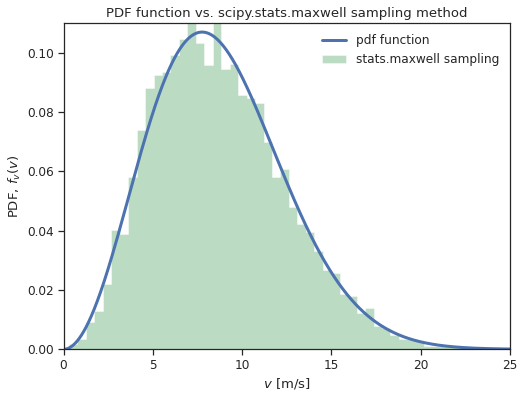

In [2]:
###define constants
kB = 1.38064852e-23  #in m^2 kg s^-2 K-1 (i.e. J K^-1)
M = 4.58574428e-25  #in kg
T = 1  #in K

###construct linspace
v = np.linspace(0, 25, 10000)

###calculate a
a = np.sqrt((kB*T)/M)

###pdf function and corresponding array
pdf = lambda v, a: np.sqrt(2/np.pi)*(((v**2)*np.exp(-(v**2)/(2*(a**2))))/(a**3))
v_pdf = pdf(v, a)

###sampling of speeds via scipy.stats.maxwell method
v_st = st.maxwell.rvs(loc=0, scale=a, size=10000)

###calculate some useful stats
mu = 2*a*np.sqrt(2/np.pi)  #i.e. most probable speed v_mp
std = np.sqrt(((a**2)*(3*np.pi - 8))/(np.pi))  #standard deviation
var = ((a**2)*(3*np.pi - 8))/(np.pi)  #variance
v_rms = np.sqrt((3*kB*T)/(M))  #rms speed
v_mean = np.sqrt((8*kB*T)/(np.pi*M))  #mean speed
print('PDF Statistics: mu={:.3f}, std={:.3f}, var={:.3f}, v_rms={:.3f}, v_mean={:.3f}'
      .format(mu, std, var, v_rms, v_mean))

###plot
fig, ax = plt.subplots(figsize=(8,6))
ax.set(xlim=(0, 25), ylim=(0,0.11), 
       title='PDF function vs. scipy.stats.maxwell sampling method',
       xlabel='$v$ [m/s]', ylabel='PDF, $f_v(v)$')
ax.plot(v, v_pdf, lw=3, label='pdf function')
ax.hist(v_st, density=True, bins='auto', histtype='stepfilled', color='g', 
        alpha=0.4, label='stats.maxwell sampling')
ax.legend(loc='best', frameon=False)
plt.show()

In [29]:
class Molecule():
    '''
    
    Methods
    -------  

    Attributes
    ----------

    '''
    nextid = 1
    def __init__(self, M, radius, x0, v0, bc, Umax, Uext, epsilon):
        self.id = Molecule.nextid  #creates unique ID number for each molecule
        Molecule.nextid += 1
        self.times = [0]
        self.M = M
        self.radius = radius
        self.bc = bc
        self.epsilon = epsilon
        self.Umax = Umax  #defines maximum value for potential to avoid asymptotic values
        self.Uext = Uext  #determines whether or not to include an external potential
        self.x, self.v = x0, v0  #holds last position and velocity of each time step
        self.x_list, self.v_list = [x0], [v0]  #lists of recorded positions and velocities
        self.x_temp, self.v_temp = [], []  #lists to hold temporary positions and velocities
        self.v2 = [pt.norm(v0).detach().item()]  #list of speeds
        
    def overlap(self, molecule):
        r = pt.norm(pt.sub(self.x, molecule.x))
        if r-(2*self.radius)*1.1 < 0: 
            return True
        else: 
            return False
        
    def boundary(self, time_step, dim):
        if self.bc == 'non-periodic':
            x, v = self.x.detach(), self.v.detach()
            u, w = pt.tensor([1.,0.]).float(), pt.tensor([0.,1.]).float()
            vx, vy = time_step*pt.abs(pt.dot(v,u)), time_step*pt.abs(pt.dot(v,w))
#             print('x0-r: {}, x1-r: {}'.format(pt.abs(x[0])-self.radius, pt.abs(dim[1]-x[0])-self.radius))
#             print('vx: {}, vy: {}'.format(vx,vy))
            if pt.abs(x[0])-self.radius < vx or pt.abs(dim[1]-x[0])-self.radius < vx:
#                 print('reflect x')
                self.v = self.v.detach()
                self.v[0] *= -1
                self.v.requires_grad = True
            if pt.abs(x[1])-self.radius < vy or pt.abs(dim[1]-x[1])-self.radius < vy:
#                 print('reflect y')
                self.v = self.v.detach()
                self.v[1] *= -1
                self.v.requires_grad = True
    
    def K(self, v, grad=False):
        K = 0.5 * v.dot(self.M.mv(v))
        if grad:
            return pt.autograd.grad([K], [v])[0]
        else:
            return K
    
    def U(self, x, molecule_x, grad=False):
        r = pt.norm(pt.sub(x, molecule_x))
        sigma = 2.5*self.radius #effective diameter of molecule in [m]
        if r != 0:
            U = (4*self.epsilon)*(((sigma/r)**12)-((sigma/r))**6)
            if grad:
                return pt.clamp(pt.autograd.grad([U], [x])[0], min=-self.Umax, max=self.Umax)
            else:
                if U >= self.Umax: U = self.Umax
                if U <= -self.Umax: U = -self.Umax
                return U
            
    def U_ext(self, x, grad=False):
        if self.Uext:
            if grad: return 0
            else: return 0
        else: return 0
        
    def acceptance(self, step_number, time_step, accepted):
        if accepted:
            new_times = [self.times[-1]]
            for i in range(step_number):
                new_times.append(new_times[-1]+time_step)
            del new_times[0]
            self.times.extend(new_times)
            self.x_list.extend(self.x_temp)
            self.v_list.extend(self.v_temp)
            self.v2.extend([pt.norm(i).detach().item() for i in self.v_temp])
            self.x_temp, self.v_temp = [], []
        else:
            self.x, self.v = self.x_list[-1], self.v_list[-1]
            self.x_temp, self.v_temp = [], []


            
class Simulation():
    '''
    
    Methods
    -------  

    Attributes
    ----------

    '''
    def __init__(self, dim=[0, 1e-8], temp=0.7*(1/1.38064852e-23), n_time=10, 
                 n_molecules=100, bc='non-periodic', m=4.58574428e-25, radius=4.335e-10, 
                 Umax=4e6, epsilon=4.11814e-20, step_number, Uext=False):
        self.kB = 1.38064852e-23  #Boltzmann constant in [(kg m^2)/(s^2 K)]
        self.a = np.sqrt((self.kB*temp)/m)  #calculate a for Maxwell-Boltmann sampling
        self.dim = dim
        self.n_time = n_time
        self.n_molecules = n_molecules
        self.step_number = step_number
        self.M = pt.tensor([[m,0],[0,m]]).float()  #mass matrix
        self.molecules = []  #list of molecules in the system
        
        ###generate list of N molecule instances
        for i in range(n_molecules):
            ###sample an initial velocity from Maxwell-Boltzmann distribution
            v_sample = st.maxwell.rvs(loc=0, scale=self.a, size=2)*np.random.choice([-1.,1.])
            v0 = pt.from_numpy(v_sample).float()
            v0.requires_grad = True
            overlap = True
            while(overlap):
                overlap = False
                ###generate a random initial position
                random_x = np.random.uniform(dim[0], dim[1]-2*radius, size=2)
                x0 = radius + pt.from_numpy(random_x).float()
                x0.requires_grad = True
                molecule = Molecule(self.M, radius, x0, v0, bc, Umax, Uext, epsilon)
                for j in self.molecules:
                    ###checks if molecule overlaps with another existing one
                    overlap = molecule.overlap(j)
                    ###if so, keep recreating molecule until no overlap
                    if overlap:
                        break
            self.molecules.append(molecule)
    
    def preview(self):
        fig, ax = plt.subplots(figsize=(7,7))
        ax.set(xlim=(self.dim[0], self.dim[1]), ylim=(self.dim[0], self.dim[1]),
               title='{}-Molecule Position and Velocity Plot'.format(self.n_molecules), 
               xlabel='x', ylabel='y')
        for i in self.molecules:
            x, v = i.x.detach().numpy(), i.v.detach().numpy()
            ax.plot(x[0], x[1], 'o', color='r', markersize=3)
            ax.quiver(x[0], x[1], v[0], v[1], color='k', width=0.003, scale_units='xy', scale=1.0)
        return plt.show()
    
    def plot_animation(self, sample_number):
        data = self.df[self.df['sample']==sample_number]
        ids = data['id'].unique().tolist()
        fig, ax = plt.subplots(figsize=(7,7))
        ax.set(xlim=(self.dim[0], self.dim[1]), ylim=(self.dim[0], self.dim[1]), 
               title='{}-Molecule motion over {} seconds (Sample {})'
               .format(self.n_molecules, self.n_time, sample_number), 
               xlabel='x', ylabel='y')
        lines = []
        x_data, y_data = [], []
        for i in ids:
            xdata = data[data['id']==i]['x'].tolist()
            ydata = data[data['id']==i]['y'].tolist()
            x_data.append(xdata)
            y_data.append(ydata)
            lines.append(ax.plot([], [], 'o', markersize=4.0)[0])

        def animate(i):
            for j, line in enumerate(lines):
                line.set_data(x_data[j][i], y_data[j][i])
            return lines            

        anim = FuncAnimation(fig, animate, frames=len(x_data[0]), blit=True, interval=100)
        return display(HTML(anim.to_jshtml())), plt.close()
    
    def plot_tracks(self, sample_number, molecule_id):
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set(xlim=(self.dim[0], self.dim[1]), ylim=(self.dim[0], self.dim[1]), 
               title='Molecule {}: Tracks over {} seconds (Sample {})'
               .format(molecule_id, self.n_time, sample_number), 
               xlabel='x', ylabel='y')
        if molecule_id == 0:
            data = self.df[self.df['sample']==sample_number]
            ids = data['id'].unique().tolist()
            for i in ids:
                plt.plot(data[data['id']==i].x, data[data['id']==i].y, lw=1)
        else:
            data = self.df[(self.df['sample']==sample_number)&(self.df['id']==molecule_id)]
            x, y = data['x'].tolist(), data['y'].tolist()
            plt.plot(x, y, lw=1, color='gray')
            plt.plot(x[0], y[0], 'o', color='red', markersize=5)
            plt.plot(x[-1], y[-1], 'o', color='green', markersize=5)
        return plt.show()
    
    def leapfrog(self, step_number, time_step, step):
        for ni,i in enumerate(self.molecules):
            gradU = i.U_ext(i.x, grad=True)
            for nj,j in enumerate(self.molecules):
                if nj != ni:
                    gradU += i.U(i.x, j.x, grad=True)
#             print('v: {}'.format(i.v))
#             print('dU: {}'.format(gradU))
            if step == 3:
                ###overwrite last proposed velocity by an additional HALF STEP
                i.v = i.v - 0.5 * time_step * gradU
                i.v_temp[-1] = i.v
            else:
                ###check boundary conditions
                i.boundary(time_step, self.dim)
                if step == 1:
                    ###update velocity by a HALF STEP
                    i.v = i.v - 0.5 * time_step * gradU
                elif step == 2:
                    ###update velocity by a FULL STEP
                    i.v = i.v - time_step * gradU
                i.v_temp.append(i.v)
                ###update position by a FULL STEP
#                 print('x: {}'.format(i.x))
#                 print('dK: {}'.format(time_step*i.K(i.v, grad=True)))
                i.x = i.x + time_step * i.K(i.v, grad=True)
                i.x_temp.append(i.x)
                
    def metropolis(self, step_number, time_step):
        dK, dU = 0, 0
        for ni,i in enumerate(self.molecules):
            ###calculate the change in kinetic and potential energy of the system
            dK += i.K(i.v_temp[-1]) - i.K(i.v)
            dU += i.U_ext(i.x_temp[-1]) - i.U_ext(i.x)
            for nj,j in enumerate(self.molecules):
                if nj > ni:
                    dU += i.U(i.x_temp[-1], j.x_temp[-1]) - i.U(i.x, j.x)
        ###calculate the total change in energy
        dE = dK + dU
        alpha = np.min([1, np.exp(dE.detach().item())])  #proposed state probability
        beta = np.random.uniform(0,1)
        if beta <= alpha:
            for i in self.molecules:
                i.acceptance(step_number, time_step, accepted=True)
            return False
        else:
            for i in self.molecules:
                i.acceptance(step_number, time_step, accepted=False)
            return True
        
    def plot_MSD(self, df):
        times = df['time'].unique().tolist()
#         simulation_MSDs = []
#         sample_MSDs = []
        cols = {'sample':}
        MSD_df = pd.DataFrame()
        samples = df['sample'].unique().tolist()
        for sample in samples:
            sdf = df[df['sample']==sample]
            n_ids = len(sdf['id'].unique().tolist())
            for n,t in enumerate(times):
                sample_MSDs.append(np.sum([i for i in sdf[sdf['time']==t]['MSD']])/n_ids)
        for MSD in sample_MSDs:
            simulation_MSDs.append(np.sum(MSD)/len(MSD))
        
#         fig, ax = plt.subplots(1,2,figsize=(7,7))
#         ax.set(xlim=(0, times[-1]), ylim=(self.dim[0], self.dim[1]), xlabel='time [s]', ylabel='displacement')
# #                title='MSD for {}-samples, {}-molecules, over {} seconds'.format(self.n_molecules),
#         ax[0].plot(t, simulation_MSDs, lw=1)
#         for i in simulation_MSDs:
#         ax[1].plot(t, x[1], 'o', lw=1)
#         return plt.show()
        
        
        return ['N/A']*len(molecule.x_list)
        
    def make_dataframe(self, sample_counter, sample_df=False):
        a, b, c, d, e = [], [], [], [], []
        f, g, h, i = [], [], [], []
        
        r0 = np.array((x[0],y[0]))
        R = []
        for z in zip(x,y):
            R.append(np.linalg.norm(r0 - np.array(z))**2)
        print('R: {}'.format(R))
        
        if sample_df:
            for m in self.molecules:
                a.extend([sample_counter]*len(m.x_list))
                b.extend([m.id]*len(m.x_list))
                ###get components of position and velocity
                x = [k[0].detach().item() for k in m.x_list]
                y = [k[1].detach().item() for k in m.x_list]
                c.extend(x)                
                d.extend(y)                
                e.extend([k[0].detach().item() for k in m.v_list])
                f.extend([k[1].detach().item() for k in m.v_list])
                g.extend(m.v2)
                ###calculate MSDs
                r0 = np.array((x[0], y[0]))
                for z in zip(x,y):
                    h.append(np.linalg.norm(r0 - np.array(z))**2)
                i.extend(m.times)
        columns = {'sample': a, 'id': b, 
                   'x': c, 'y': d, 
                   'vx': e, 'vy': f, 'v^2': g, 
                   'MSD': h, 'time': i}
        return pd.DataFrame(columns)
                               
    def sampler(self, n_samples, sample_counter):
        for t in range(self.n_time):
            rejected = True
            rejects = 0
            ###keeps trying until it gets an accepted state
            while(rejected):
                print('\rSample: {} of {}, Time: {} of {}, Rejections: {}'
                      .format(int(sample_counter), int(sample_counter), 
                              int(t+1), int(self.n_time),
                              int(rejects)), end='')
                rejected = False
                ###generates a random number of steps each time interval
                step_number = self.step_number #int(np.random.uniform(20, 50))
                ###corresponding random time step
                time_step = 1/step_number
                ###start leapfrog algorithm
                self.leapfrog(step_number, time_step, step=1)
                for step in range(step_number-1):
                    self.leapfrog(step_number, time_step, step=2)
                self.leapfrog(step_number, time_step, step=3)
                ###verify proposed positions and velocities
                rejected = self.metropolis(step_number, time_step)
                if rejected:
                    rejects += 1
        print('\rSample: {} of {}, Time: {} of {}, Rejections: {}'
                      .format(int(sample_counter), int(sample_counter), 
                              int(t+1), int(self.n_time),
                              int(rejects)))
        print('Sampling is now complete, preparing dataframe...')
        return self.make_dataframe(sample_counter, sample_df=True)
    
    def run_simulation(self, n_samples=100):
        print('[[ Simulation started ]]')
        ti = time.time()
        df = self.make_dataframe(0)
        for sample in range(n_samples):
            data = self.sampler(n_samples, sample+1)
            df = df.append(data, ignore_index=True)
        df = df.sort_values(by=['sample', 'time', 'id'])
        df[['sample','id']] = df[['sample','id']].astype(int)
        self.df = df
        tf = time.time()
        print('[[ Simulation completed! Duration: {:.2f} seconds ]]'.format(round(tf - ti, 2)))
        return df



###mass: [4.58574428e-25 kg], [276.16 g/mol], [1]
m = 1
###radius: [5.50483e-10 m], [0.550483 nm], [5.50483 A]
radius = 0.4335
###dispersion energy: [4.11814e-20 J], [24.8 kJ/mol], [5.6667 kcal/mol], [0.257027 eV]
epsilon = 0.257027
#[1], [0.4335], [0.257027], [0., 25.], 0.3*(1/1.38064852e-23)
    
###set other simulation parameters
dim = [0., 20.] #dimensions of simulations space
temp = 0.3*(1/(1.38064852e-23))  #absolute temperature in [K]
n_time = 5  #duration of time (in lab-time) each iteration in [s]
n_molecules = 25  #number of molecules
step_number = 25  #number of L steps of Leapfrog integration
Umax = 40
bc = 'non-periodic'  #periodic or non-periodic boundary conditions

###initialize simulation
sim = Simulation(dim=dim, temp=temp, n_time=n_time, n_molecules=n_molecules, bc=bc, 
                 m=m, radius=radius, Umax=Umax, epsilon=epsilon, step_number)

###plot initial conditions
sim.preview()

IndentationError: expected an indented block (<ipython-input-29-1c1e18f28fdf>, line 257)

In [4]:
df = sim.run_simulation(n_samples=1)
df[(df['sample']==1) & (df['id']==1)].sort_values(by=['id', 'v^2']).head()

[[ Simulation started ]]
Sample: 1 of 1, Time: 5 of 5, Rejections: 0
Sampling is now complete, preparing dataframe...
[[ Simulation completed! Duration: 68.41 seconds ]]


,sample,id,x,y,vx,vy,v^2,MSD,time
182,1,1,15.964445,14.713255,0.522822,-0.131146,0.539019,N/A,5.000000
181,1,1,15.953321,14.716044,0.522867,-0.131025,0.539034,N/A,4.978723
180,1,1,15.942196,14.718832,0.522898,-0.130944,0.539044,N/A,4.957447
179,1,1,15.931070,14.721618,0.522930,-0.130864,0.539056,N/A,4.936170
178,1,1,15.919944,14.724402,0.522962,-0.130783,0.539067,N/A,4.914894


In [5]:
sim.plot_animation(sample_number=1)

(None, None)

In [6]:
#particle_id=0 will plot for all particles
sim.plot_tracks(sample_number=1, molecule_id=0)

TypeError: plot_tracks() got an unexpected keyword argument 'particle_id'

In [ ]:
sim.plot_MSD(df)

In [30]:
'''

TO DO:

- Calculate MSD
- Put in Periodic Boundary Conditions
- Find a way to improve performance

'''

# x, y = np.random.rand(5), np.random.rand(5)

# print('x: {}\ny: {}\n'.format(x,y))

# r0 = np.array((x[0],y[0]))
# R = []
# for z in zip(x,y):
#     R.append(np.linalg.norm(r0 - np.array(z))**2)
# print('R: {}'.format(R))

z = [1, 1, 1, 1, 1]

[[] for i in range(len(z))]

[[], [], [], [], []]